In [1]:
import simulate_data
import remove_data
import matrix_completion
import trunc_nnm
import errors

from sklearn.preprocessing import normalize
import numpy as np
import numpy.linalg as la
import pandas as pd

In [2]:
# simulate data
sim_df = simulate_data.sim_data(**simulate_data.sim_params)

# drop categorical feature for now
sim_df = sim_df.drop("Group", axis=1)

# Normalize data by feature (axis=0)
# norms we could use for re-scaling later
sim_norm, norms = normalize(sim_df, axis=0, return_norm=True)
pd.DataFrame(sim_norm).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.070484,0.084267,0.157622,0.000000,0.408248,0.000000,0.102062,0.0,0.000000,0.027822,0.080768
1,0.095545,0.106923,0.000000,0.000000,0.000000,0.150756,0.102062,0.0,0.000000,0.058997,0.103462
2,0.136269,0.039334,0.157622,0.117041,0.000000,0.000000,0.102062,0.0,0.103052,0.064674,0.043267
3,0.131570,0.106595,0.078811,0.117041,0.000000,0.000000,0.102062,0.0,0.000000,0.127137,0.106011
4,0.115907,0.105039,0.078811,0.117041,0.000000,0.000000,0.102062,0.0,0.000000,0.074595,0.102355


In [3]:
# NNM parameters
parameters = {"eps_outer": 1e-6,
              "eps_inner": 1e-6,
              "beta": 1,
              "max_iter_outer": 100,
              "max_iter_inner": 100}

### How do error rates vary by rate of missingness?

In [4]:
results_lst = []

for missingness_pct in np.arange(0, 100, 5):
    sim_obs = remove_data.missing_at_random(sim_norm, perc_remove=missingness_pct, rand_seed=23)
    
    rank = la.matrix_rank(sim_norm)
    sim_recovered_nnm = trunc_nnm.truncated_NNM(rank, parameters, sim_obs)
    nnm_error = la.norm(sim_norm - sim_recovered_nnm, ord='fro')

    sim_obs = remove_data.missing_at_random(sim_norm, perc_remove=missingness_pct, rand_seed=23)

    sim_recovered_svt = matrix_completion.svt(sim_obs, tau=0.5, stop_threshold=1e-3, max_iter=2000)
    svt_error = la.norm(sim_norm - sim_recovered_svt, ord='fro')
    
    results_lst.append([missingness_pct, svt_error, nnm_error])

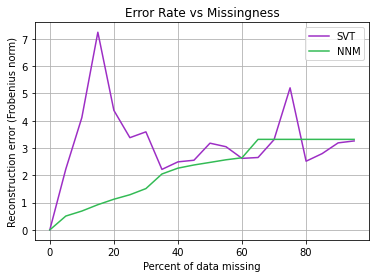

In [6]:
results_df = pd.DataFrame(results_lst, columns=["missingness", "SVT", "NNM"]).set_index("missingness")

errors.line_plot(results_df.index, results_df.SVT, results_df.NNM, 
                 save=False,
                 title="Error Rate vs Missingness",
                 xlabel="Percent of data missing",
                 ylabel="Reconstruction error (Frobenius norm)")

Error rates increased sharply from no missingness to about 10% missingness, then increased at a lesser rate.

### How does missingness affect error rates by rank?

In [ ]:
missingness_rank_df = pd.DataFrame(np.arange(0, 100, 5).tolist(), columns=["missingness"])

for rank in range(1, 11):
    error_lst = []
    for missingness in np.arange(0, 100, 5):
        # create rank r matrix
        sim_arr = simulate_data.create_rank_r_matrix(rank, 100, 10)

        # normalize
#         sim_norm, norms = normalize(sim_arr, axis=0, return_norm=True)

        # remove data at random
        sim_obs = remove_data.missing_at_random(sim_arr, perc_remove=missingness, rand_seed=23)

        sim_recovered_svt = matrix_completion.svt(sim_obs, tau=5)
        svt_error = la.norm(sim_arr - sim_recovered_svt, ord='fro')
        
        error_lst.append(svt_error)

    missingness_rank_df[f"rank_{rank}"] = error_lst

In [ ]:
# results_df = pd.DataFrame(results_lst, columns=["missingness", "SVT", "NNM"]).set_index("missingness")
missingness_rank_df.set_index("missingness").plot(title="Reconstruction Error by Rank and Missingness")
pass

##### Here we hold the error rate at 40% and change $\tau$ for SVT

In [ ]:
tau_lst = []

for tau in np.arange(0, 10, 1):
    sim_obs = remove_data.missing_at_random(sim_norm, perc_remove=40, rand_seed=23)
    
    sim_recovered_svt = matrix_completion.svt(sim_obs, tau=tau)
    svt_error = la.norm(np.round(sim_norm, 4) - np.round(sim_recovered_svt, 4), ord='fro')
    
    tau_lst.append([tau, svt_error])

In [ ]:
tau_df = pd.DataFrame(tau_lst, columns=["tau", "error"]).set_index("tau")
tau_df.plot(title="Error rate depending on tau")

SVT seems to want $\tau$ to be somewhere midway between 0 and the rank of the original matrix. Should test on other data.

### How do error rates vary by rank of the matrix?

In [9]:
# NNM parameters
parameters = {"eps_outer": 1e-6,
              "eps_inner": 1e-6,
              "beta": 1,
              "max_iter_outer": 100,
              "max_iter_inner": 100}


Here we vary rank for a synthetic dataset with 10% missing values

In [10]:
results_lst = []
n = 20
p = 10
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

for rank in range(1,p):

    # Produce r-rank data
    data = simulate_data.create_rank_r_matrix(rank, n, p)

    # Set to only 10% missing
    sim_obs = remove_data.missing_at_random(data, perc_remove=10, rand_seed=23)

    sim_recovered_svt = matrix_completion.svt(sim_obs, tau=10, stop_threshold=.0001)
    svt_error = la.norm(data - sim_recovered_svt, ord='fro')

    # reproduce same matrix
    sim_obs = remove_data.missing_at_random(data, perc_remove=10, rand_seed=23)
    sim_recovered_nnm = trunc_nnm.truncated_NNM(rank, parameters, sim_obs)
    nnm_error = la.norm(data - sim_recovered_nnm, ord='fro')

    results_lst.append([rank, svt_error, nnm_error])

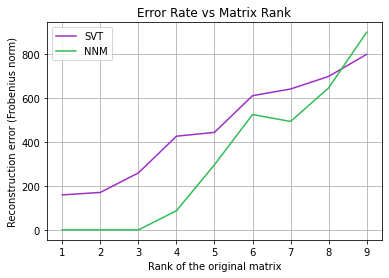

In [11]:
results_df = pd.DataFrame(results_lst, columns=["rank", "SVT", "NNM"]).set_index("rank")

errors.line_plot(results_df.index, results_df.SVT, results_df.NNM, 
                 save=False,
                 title="Error Rate vs Matrix Rank",
                 xlabel="Rank of the original matrix",
                 ylabel="Reconstruction error (Frobenius norm)")

The reconstruction error increases fairly linearly with rank.

### How do error rates vary by the type of missingness?

In [ ]:
# remove the last column
original_normalized_arr = sim_norm[:,:10]
original_normalized_df = pd.DataFrame(original_normalized_arr, columns=sim_df.columns[:10])

In [ ]:
def conditionally_remove_data(df, perc_missing):

    # make Income missing conditional on age
    sim_df = remove_data.missing_conditional_continuous(df, 
                                                     "Income", 
                                                     "Income", 
                                                     percent_missing=perc_missing)

    # make Age missing conditional on itself
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "Age", 
                                                     "Age", 
                                                     percent_missing=perc_missing)

    # make NChild missing conditional on Continuous_EvenLikelihood_0
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "NChild", 
                                                     "Continuous_EvenLikelihood_0", 
                                                     percent_missing=perc_missing)


    # # make Continuous_LowLikelihood_0 missing conditional on Continuous_HighLikelihood_0
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "Continuous_LowLikelihood_0", 
                                                     "Continuous_HighLikelihood_0", 
                                                     percent_missing=perc_missing)

    # # make Continuous_EvenLikelihood_0 missing conditional on itself
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "Continuous_EvenLikelihood_0", 
                                                     "Continuous_EvenLikelihood_0", 
                                                     percent_missing=perc_missing)

    # # make Continuous_HighLikelihood_0 missing conditional on itself
    sim_df = remove_data.missing_conditional_continuous(sim_df, 
                                                     "Continuous_HighLikelihood_0", 
                                                     "Continuous_HighLikelihood_0", 
                                                     percent_missing=perc_missing)

    # conditionally remove entries from each discrete variable
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'InCensus', perc_missing)
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'Discrete_LowLikelihood_0', perc_missing)
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'Discrete_EvenLikelihood_0', perc_missing)
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'Discrete_HighLikelihood_0', perc_missing)
    sim_df = remove_data.missing_conditional_discrete(sim_df, 
                                                    'Discrete_LowLikelihood_0', perc_missing)
    
    return sim_df

In [ ]:
# test the conditionally_remove_data function
sim_conditional_missing = conditionally_remove_data(original_normalized_df, perc_missing=30)

In [ ]:
# confirm that Continuous_LowLikelihood_0 is missing for those with low values of Continuous_HighLikelihood_0
sim_conditional_missing[['Continuous_HighLikelihood_0', 'Continuous_LowLikelihood_0']].sort_values("Continuous_HighLikelihood_0")[:10]

In [ ]:
# check total missingness in conditional missing
conditional_total_missingness = pd.DataFrame(sim_conditional_missing).isnull().sum().sum() / pd.DataFrame(sim_conditional_missing).size
print(conditional_total_missingness)

# view missingness for features in conditional missing
sim_conditional_missing.isnull().mean()

In [ ]:
# create randomly missing data matching the missingness of the conditional data
sim_random_missing = remove_data.missing_at_random(original_normalized_arr, perc_remove=conditional_total_missingness*100, rand_seed=23)

In [ ]:
# check total missingness in random missing
print(pd.DataFrame(sim_random_missing).isnull().sum().sum() / pd.DataFrame(sim_random_missing).size)

# view missingness for features in random missing
pd.DataFrame(sim_random_missing, columns=original_normalized_df.columns).isnull().mean()

In [ ]:
results_lst = []

for missingness_pct in range(0, 100, 5):
    sim_conditional_missing = conditionally_remove_data(original_normalized_df, perc_missing=missingness_pct)
    
    # check total missingness in conditional missing
    conditional_total_missingness = pd.DataFrame(sim_conditional_missing).isnull().sum().sum() / pd.DataFrame(sim_conditional_missing).size
    
    # create randomly missing data matching the missingness of the conditional data
    sim_random_missing = remove_data.missing_at_random(original_normalized_arr, perc_remove=conditional_total_missingness*100, rand_seed=23)

    # random missing
    sim_recovered_random_svt = matrix_completion.svt(sim_random_missing, tau=5)
    random_svt_error = la.norm(np.round(original_normalized_arr, 4) - np.round(sim_recovered_random_svt, 4), ord='fro')

#     sim_recovered_random_nnm = trunc_nnm.truncated_NNM(10, parameters, sim_random_missing)
#     random_nnm_error = la.norm(np.round(original_normalized_data, 4) - np.round(sim_recovered_random_nnm, 4), ord='fro')

    # conditional missing
    sim_recovered_conditional_svt = matrix_completion.svt(sim_conditional_missing, tau=5)
    conditional_svt_error = la.norm(np.round(original_normalized_arr, 4) - np.round(sim_recovered_conditional_svt, 4), ord='fro')

#     sim_recovered_conditional_nnm = trunc_nnm.truncated_NNM(10, parameters, sim_conditional_missing)
#     conditional_nnm_error = la.norm(np.round(original_normalized_data, 4) - np.round(sim_recovered_conditional_nnm, 4), ord='fro')

    results_lst.append([conditional_total_missingness, random_svt_error, conditional_svt_error])

In [ ]:
svt_errors = pd.DataFrame(results_lst, columns=['missingness','random','conditional']).set_index('missingness')

In [ ]:
svt_errors

In [ ]:
errors.line_plot(svt_errors.index*100, svt_errors.random, svt_errors.conditional,
                 save=True,
                 title="Error Rate vs Type of Missingness",
                 xlabel="Percent of data missing",
                 ylabel="Reconstruction error (Frobenius norm)")

The error rate for the randomly missing data is strictly greater than the error rate for conditionally missing data. This is consistent across many randomizations. Though this finding may be particular to the data and implementation of removing values, we have a theory that helps explain this phenomenon. When entries are missing based on features within the data, the missingness has structure. In other words, being missing may indicate something about the entry (high or low value) or about another feature that is related to it. Introducing this structure into the data may help the SVT algorithm slightly by indicating subtle information about the missing entries. In contrast, entries that are missing at random do not signal anything about the missing value.

With both randomly missing data and conditionally missing data, the error rates increase quickly going from no missing data to about 10% missing. Then, the error rate increases relatively linearly.

##### How were the missing data produced?

Both the randomly missing data and the conditionally missing data were constructed from the same synthetic dataset. The randomly missing dataset was constructed by selecting random elements to drop from the data. Therefore, in expectation, each feature should have the same amount of missingness. 

The conditional data was generated by one of two processes depending on whether the feature is continuous or binary. For continuous features, values were removed probablistically based on values within the feature or values from another feature. For instance, Income values could be more likely missing if income is a low value. Alternatively, Income values could be removed based on whether age is a high or low value. For binary features, we randomly assigned different likelihoods of missingness to values of 0 and 1. Thus, values of 1 may be removed at a higher rate than values of 0.